<h1 style="text-align: center;"> Social Choice - Project Part 2</h1>

<h3 style="text-align: center;"> Adi Levi</h1>

## Topic:
Following part 1 where we described the paper and presented the main result:<br>
<ol>
    <li> The greedy robust optimization algorithm with minimax regret, provides an effective solution
in polynomial time $O(nm^3K^2)$ where $K$ is the slate size, $m$ is the number of candidates, and $n$
        is the number of voters.</li>
    <li> The greedy-MMR algorithm provides an approximation of the optimal slate selection, with a factor of approximation being $1-\frac{1}{e^{\frac{1}{\alpha}}}$, which depends on the value of $\alpha$. The closer $\alpha$ is to 1,
the closer the approximation is to the optimal solution.</li>
    </ol>
    
In this part, we are implementing the Greedy and Optimal algorithms mentioned in the paper. <br>
We will compare the two in terms of running times and performance (MMR) as a function of the slate size - $K$ and number of candidates - $m$<br>

Furthermore, we will apply a random elicitation strategy and show that Greedy MR is non-increasing.<br>
We are planning to run the models on the Sushi dataset that consists of 5000 complete user preference rankings over 10 varieties of sushi. <br>
Another code we used to inspect the effect of $m$ on the runtime of the greedy algorithm is the Sushi dataset that consists of 5000 partial user preference rankings over 100 varieties of sushi. <br>

In order to create the partial information preferences, we will randomly choose pairwise compressions for each voter. We will later compare our results to the findings in the article.

## Dataset:
The Sushi dataset consists of 5000 complete user preference rankings over 10 varieties of sushi. <br>
Each sushi has an ID:<br>
0: ebi (shrimp) <br>
1: anago (sea eel)<br>
2: maguro (tuna)<br>
3: ika (squid)<br>
4: uni (sea urchin)<br>
5: ikura (salmon roe)<br>
6: tamago (egg)<br>
7: toro (fatty tuna)<br>
8: tekka_maki (tuna roll)<br>
9: kappa_maki (cucumber roll)<br>
<br>
The preferences profiles are full and ordered in ascending order from left to right.<br>
We will now process the data and transform it to partial information preference profiles <br> 

## Imports:

In [1]:
import random
import numpy as np
import itertools
import time
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt


C:\Users\adile\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\adile\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\adile\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Dataset Preprocessing:

In [2]:
def create_full_profiles():
    """
    Create a dictionary of preference profiles from the sushi dataset
    :return: dictionary of lists: full preference profiles
    """
    Sushi_file = "sushi3a.5000.10.order"
    data_file = open(Sushi_file, "r")
    data_lines = data_file.read().splitlines()[1:]
    full_profiles = {}
    for i, line in enumerate(data_lines):
        profile = line.split(" ")[-1:-11:-1]
        profile = [int(c) for c in profile]
        full_profiles[i] = profile
    return full_profiles


def get_partial_profiles(full_profiles, candidates, m=10):
    """
    Get partial profiles from the full profiles
    :param full_profiles: dictionary of lists: preference profiles
    :param candidates: list: list of candidates
    :param m: int: number of candidates in the partial profile
    :return: dictionary of lists: partial preference profiles
    """
    partial_profiles = {}
    new_candidates = random.sample(candidates, m)
    for idx, profile in full_profiles.items():
        x = [v for v in profile if v in new_candidates]
        size = random.randint(2, m)
        idx2sample = sorted(random.sample(range(len(x)), size))
        partial_profiles[idx] = [x[i] for i in idx2sample]
    return partial_profiles, new_candidates


def get_random_profiles(profiles, num_voters):
    """
    Get random profiles from a given dictionary of profiles
    :param profiles: dictionary of lists: preference profiles
    :param num_voters: int: number of voters in the random profiles
    :return: dictionary of lists: random preference profiles
    """
    random_profiles_keys = random.sample(list(profiles.keys()), num_voters)
    random_profiles = {k:v for k,v in profiles.items() if k in random_profiles_keys}
    return random_profiles


def get_below_above_profiles(profiles):
    """
    Change a given preference profile to list of dictionaries of candidates' pairwise relationship in the preference profile
    :param profiles: list of lists: list of preference profiles
    :return: list of dictionary: list of candidates ranked above and below each candidate in the preference profile
    """
    ranked_above = []
    ranked_below = []
    for i, profile in enumerate(profiles):
        above_profile = {}
        below_profile = {}
        for candidate in profile:
            below_profile[candidate] = [x for idx, x in enumerate(profile) if profile.index(x) > profile.index(candidate)]  # the candidates that are
            # ranked lower than candidate
            above_profile[candidate] = [x for idx, x in enumerate(profile) if profile.index(x) < profile.index(candidate)]  # the candidates that are
        ranked_above.append(above_profile)
        ranked_below.append(below_profile)
    return ranked_above, ranked_below


### We will define: 
<ol>
    <li>$PMR(\bar{a},\bar{w},p_i)=max_{w\in u_i(\bar{w})}PMR(u_i(\bar{a}),\left\{ w \right\},p_{i})$ <br></li>
    <li>$PMR(\bar{a},\bar{w},p)=\sum_{i\in N}^{}PMR(\bar{a},\bar{w},p_i)$<br></li>
    <li>$u_i(\bar{a})=\left\{ a\in \bar{a}:\neg \: \exists \:  a'\in \bar{a} \:\: s.t \:\: a'\succ _{i} a  \right\}$ -
Set of elements from $\bar{a}$ that are not dominated by any element in $\bar{a}$.</li>
    <li>$u_i(\bar{a})^+_w=\left\{ a\in u_i(\bar{a}):a\succ _iw \right\}$ - Set of elements from $u_i(\bar{a})$ that are dominating $w$.<br></li>
    <li>$B_i(\bar{a},w)=\left\{ b\in A:\exists a\in u_i(\bar{a})_w^+, a\succ _ib\succ _iw \right\}$ - The minimal gap between candidate $w$ and the most dominated candidate in the slate of $\bar{a}$ for a profile in $C(p_{i})$</li>
    <li>$B_{i}^{'}(a,w)=\left\{ B\in A / \bar{a} : b \ngtr _{i} w \;\; and \;\; \forall a\in u_i(\bar{a}), a \nsucc_{i} b\right\}$ - The maximal gap between candidate $w$ and the most dominated candidate in the slate of $\bar{a}$ for a profile in $C(p_{i})$</li>
     <li>$rel(\bar{a})$ - slate that contains only the candidate in $\bar{a}$ that appear in the partial profile $p_{i}$</li>
</ol>

## Optimal algorithm:
The regret-optimal slate $\bar{a}_{p}^{*}$ can be determined by first computing $PMR(\bar{a},\bar{w},p)$ for all pairs
of K-sets $\bar{a}$, $\bar{w}$, maximizing over $\bar{w}$ to determine $MR(\bar{a},p)$, then minimizing over these terms to compute $MMR(p)$.<br><br>
Here you can see the following pseudocode of the algorithm <b> we wrote</b> as we interpreted from the paper: <br>
<img src="optimal_algorithm.JPG" alt="Alternative text"  width="500" height="600"/>

In [3]:
def get_all_k_slate(k):
    """
    get all the possible slates of size k
    :param k: int: the size of the slate
    :return: list of sets: of all the possible slates of size k
    """
    return list(itertools.combinations(candidates, k))

def get_u(slate, above):
    """
    get the candidate that is ranked highest in the slate according to the profile
    :param slate: set: slate of size k
    :param above: dictionary: candidates' rank in the partial profile
    :return: top: list: the candidates that are ranked highest in the slate according to the profile
    """
    top = []
    for y in slate:
        if y in above.keys():
            if len([x for x in slate if x in above[y]]) == 0:
                top.append(y)
        else:
            top.append(y)
    return top


def get_B_tag(slate, u_i, w, below, above, candidates):
    """
    get the number of candidates that are ranked higher than w and are not in the slate and are not ranked lower than u_i
    :param slate: set: slate of size k
    :param u_i: list: the candidates that are ranked highest in the slate
    :param w: int: the candidate that is ranked highest in the relevant adversarial slate
    :param below: dictionary: candidates' rank in the partial profile below the current candidate
    :param above: dictionary: candidates' rank in the partial profile above the current candidate
    :param candidates: list: list of all the candidates
    :return: int: the number of candidates that are ranked higher than w and lower than u_i and are not in the slate
    """

    # get the candidates that are not ranked higher than w and are not in the slate
    B_tag = []
    temp =[x for x in candidates if x not in slate and x!= w] # all the candidates that are not in the slate and not w
    for b in temp:
        if w in above.keys():
            if b not in above[w]:
                B_tag.append(b)
        else:
            B_tag.append(b)

    # remove the candidates that are  ranked lower than u_i
    B= B_tag.copy()
    for b in B:
        for u in u_i:
            if u in below.keys():
                if b not in below[u]:
                    continue
                else:
                    B_tag.remove(b)
                    break
            else:
                continue
    return len(B_tag)



def get_B(u_i_plus,w,below, above,candidates):
    """
    get the number of candidates that are ranked higher than w and are ranked lower than u_i_plus
    :param u_i_plus: int: the candidate that is ranked highest in the relevant slate and is ranked above w
    :param w: int: the candidate that is ranked highest in the relevant adversarial slate
    :param below: dictionary: candidates that are ranked in the partial profile below the current candidate
    :param above: dictionary: candidates that are ranked in the partial profile above the current candidate
    :param candidates: list: list of all the candidates
    :return: int: the number of candidates that are ranked higher than w and are ranked lower than u_i_plus
    """
    B = []
    # all the candidates that are ranked higher than w
    if w in above.keys():
        B=[x for x in below.keys() if x in above[w]]

    # remove all the candidates that are in u_i_plus (because they are counted in |u_i_plus|)
    temp = B.copy()
    for b in temp:
        for u in u_i_plus:
            if b==u:
                B.remove(b)
                break

    # remove all the candidates that are not ranked lower than u_i_plus
    temp = B.copy()
    for b in temp:
        flag = True
        for u in u_i_plus:
            if b in below[u]:
                flag = False
                break
        if flag:
            B.remove(b)
    return len(B)


def compute_PMR_optimal(below, above, slate_a, slate_w, candidates):
    """
    compute the PMR of a slate given a partial profile
    :param below: dictionary: candidates' rank in the partial profile below the current candidate
    :param above: dictionary: candidates' rank in the partial profile above the current candidate
    :param slate_a: set: slate of size k
    :param slate_w: set: the adversarial slate that consist of the candidates that are in the partial profile
    :param candidates: list: list of all the candidates
    :return: int: the PMR of the slate given the partial profile
    """
    u_iw = get_u(slate_w, above)
    u_ia = get_u(slate_a, above)

    # find if there is a candidate in the slate_a that is ranked higher than w
    below_a = []
    for w in u_iw:
        for a in slate_a:
            if a in below.keys() and w in above.keys():
                if w in below[a]:
                    below_a.append(w)
                    break
    rest = [x for x in u_iw if x not in below_a]

    PMR = -float("inf")
    for w in below_a:
        u_i_plus = [a for a in u_ia if a in above[w]]
        PMR = max(-get_B(u_i_plus, w, below, above, candidates) - len(u_i_plus), PMR)
    for w in rest:
        if w not in u_ia:
            PMR = max(get_B_tag(slate_a, u_ia, w, below, above, candidates) + 1, PMR)
        else:
            PMR = max(0, PMR)
    return PMR


def optimal_algorithm(k, below_profile, above_profile, candidates):
    """
    get the optimal slate of size k
    :param k: int: the size of the slate
    :param below_profile: dictionary: candidates' rank in the partial profile below the current candidate
    :param above_profile: dictionary: candidates' rank in the partial profile above the current candidate
    :param candidates: list: list of all the candidates
    :return optimal slate: set: the optimal slate of size k, PMR_list: list of PMR of all the queries
    """
    MMR = float("inf")
    all_K_slate =get_all_k_slate(k)
    for a_slate in all_K_slate:
        MR = -float("inf")
        for w_slate in all_K_slate:
            if a_slate == w_slate:
                continue
            PMR = 0
            for below,above in zip(below_profile,above_profile):
                PMR += compute_PMR_optimal(below, above, a_slate, w_slate, candidates)
            
            if PMR > MR:
                MR = PMR
        if MR< MMR:
            MMR = MR
            optimal_slate= a_slate
    return optimal_slate , MMR

### We will define: 
<ol>
    <li>$PMR(a,w,p|\bar{a})=PMR(\bar{a}\cup {a},\bar{a}\cup {w},v)$
Given $\bar{a}$ set, a is a proposed additional option, and w is an adversarial witness.</li>
    <li>$MR(a,p|\bar{a})=max_{w\in A}PMR(a,w,p|\bar{a})$</li>
    <li>$MMR(p|\bar{a})=min_{a\in A}MR(a,p|\bar{a})$</li>
    <li>$T_{i}(a,b)=\left\{ b':a\succ _ib'\succ _ib \right\}$- The minimal gap between $a$ and $b$ in partial profile $p_{i}$</li>
    
</ol>






## Greedy algorithm:
<br>
We would like to implemment the Greedy algorithm from the paper:<br>
<img src="algorithm.JPG" alt="Alternative text" />


<br>Instead of computing the $MR(\bar{a},p)$ for each size $K$ slate $\bar{a}$ and selecting the slate that minimizes regret in the optimal algorithm (costs $O(nm^{2K+1} K^2 )$), we are building the slate $\bar{a}$ by iterations until we get a slate of size $K$ (costs $O(nm^3 K^2 )$).<br>
At each iteration $k\leqslant K$, we add the option with the least max regret given the prior items, to the slate.<br>

In [4]:
def get_u(slate, above):
    """
    get the candidate that is ranked highest in the slate according to the profile
    :param slate: set: slate of size k
    :param above: dictionary: candidates' rank in the partial profile
    :return: top: list: the candidates that are ranked highest in the slate according to the profile
    """
    top = []
    for y in slate:
        if y in above.keys():
            if len([x for x in slate if x in above[y]]) == 0:
                top.append(y)
        else:
            top.append(y)
    return top


def get_T(a, b, below, above):
    """
    get the number of candidates that are ranked lower than a and higher than b
    :param a: int: the candidate that is ranked highest in the relevant slate
    :param b: int: the candidate that is ranked highest in the relevant adversarial slate
    :param below: dictionary: candidates' rank in the partial profile below the current candidate
    :param above: dictionary: candidates' rank in the partial profile above the current candidate
    :return:  int: the number of candidates that are ranked lower than a and higher than b
    """
    above_b= [b_tag for b_tag in above.keys() if b_tag in above[b]]
    T = [b_tag for b_tag in below.keys() if b_tag in below[a] and b_tag in above_b]
    return len(T)


def get_B_tag(slate, u_i, w, below, above, candidates):
    """
    get the number of candidates that are ranked higher than w and are not in the slate and are not ranked lower than u_i
    :param slate: set: slate of size k
    :param u_i: list: the candidates that are ranked highest in the slate
    :param w: int: the candidate that is ranked highest in the relevant adversarial slate
    :param below: dictionary: candidates' rank in the partial profile below the current candidate
    :param above: dictionary: candidates' rank in the partial profile above the current candidate
    :param candidates: list: list of all the candidates
    :return: int: the number of candidates that are ranked higher than w and lower than u_i and are not in the slate
    """

    # get the candidates that are not ranked higher than w and are not in the slate
    B_tag = []
    temp =[x for x in candidates if x not in slate and x!= w] # all the candidates that are not in the slate and not w
    for b in temp:
        if w in above.keys():
            if b not in above[w]:
                B_tag.append(b)
        else:
            B_tag.append(b)

    # remove the candidates that are  ranked lower than u_i
    B= B_tag.copy()
    for b in B:
        for u in u_i:
            if u in below.keys():
                if b not in below[u]:
                    continue
                else:
                    B_tag.remove(b)
                    break
            else:
                continue
    return len(B_tag)


def compute_PMR_greedy(slate, below, above, a, w, candidates):
    """
    compute the PMR of a candidate a in a slate of size k
    :param slate: set: slate of size k-1
    :param below: dictionary: candidates' rank in the partial profile below the current candidate
    :param above: dictionary: candidates' rank in the partial profile above the current candidate
    :param a: the candidate that we want to compute its addition to PMR
    :param w: the adversarial that we compute the PMR against
    :param candidates: list: list of all the candidates
    :return: int: the PMR of the slate with the addition of 'a' against w
    """
    slate_a = slate.copy()
    slate_a.add(a)
    slate_w = slate.copy()
    slate_w.add(w)
    u_iw = get_u(slate_w, above)

    PMR=0
    if a in below.keys() and w in above.keys():
        # case 1: 'a' is ranked higher than w
        if a in above[w]:
            if len([b for b in slate if b in below[a]])==len(slate):
                PMR = -float("inf")
                for b in u_iw:
                    PMR = max(-get_T(a, b, below, above) - 1, PMR)

        # case 2: 'a' is not ranked higher than w : 'a' is ranked lower than w
        else:
            if w in u_iw:  # no b in the slate is ranked higher than w
                u_ia = get_u(slate_a, above)
                PMR = get_B_tag(slate_a, u_ia, w, below, above, candidates) + 1

    # case 2: 'a' is not ranked higher than w : 'a' and w are incomparable
    else:
        if w in u_iw:  # no b in the slate is ranked higher than w
            u_ia = get_u(slate_a, above)
            PMR = get_B_tag(slate_a, u_ia, w, below, above, candidates) + 1
    return PMR


def greedy_algorithm(K, below_profile, above_profile, candidates):
    """
    compute the slate of size K using the greedy algorithm
    :param K: int: the size of the slate
    :param below_profile: dictionary: candidates' rank in the partial profile below the current candidate
    :param above_profile: dictionary: candidates' rank in the partial profile above the current candidate
    :param candidates: list: list of all the candidates
    :return: set: the slate of size K
    """
    slate = set()
    for i in range(1, K + 1):
        MMR = float("inf")
        for a in candidates:
            MR = - float("inf")
            for w in candidates:
                if w != a:
                    PMR = 0
                    for below,above in zip(below_profile,above_profile):
                        PMR += compute_PMR_greedy(slate, below, above, a, w, candidates)
                    if PMR > MR:
                        MR = PMR
                        w_k1 = w
            if MR < MMR:
                MMR = MR
                optimal = a
                MR_K = MR
                w_k = w_k1
        if i == K:
            slate_k_minus_1 = slate.copy()
        slate.add(optimal)
    return slate, MMR, slate_k_minus_1, w_k, optimal, MR_K


## Discussion:

### Greedy regret VS Optimal regret as a function of K
<br>
We computed the average MMR (for 20 random profiles) for the optimal and greedy algorithms, on 100 random voters for different sizes of K<br>

In [5]:
candidates =list(np.arange(0,10))
K_list = [1,2,3]

num_samples =20
full_profiles = create_full_profiles()
num_voters =100

MMR_greedy_list = []
MMR_optimal_list =[]
for k in K_list:
    print(k)
    avg_MMR_greedy =0
    avg_MMR_optimal =0
    for i in range(num_samples):
        partial_profiles, new_candidates = get_partial_profiles(full_profiles, candidates)
        random_partial_profiles = get_random_profiles(partial_profiles, num_voters)
        random_partial_profiles = list(random_partial_profiles.values())
        below_profile, above_profile = get_below_above_profiles(random_partial_profiles)
        _, MMR_greedy, _, _, _, _ = greedy_algorithm(k, below_profile, above_profile, new_candidates)
        _, MMR_optimal = optimal_algorithm(k, below_profile, above_profile, new_candidates)
        avg_MMR_greedy +=MMR_greedy
        avg_MMR_optimal +=MMR_optimal
    MMR_greedy_list.append(avg_MMR_greedy/num_samples)
    MMR_optimal_list.append(avg_MMR_optimal/num_samples)

1
2
3


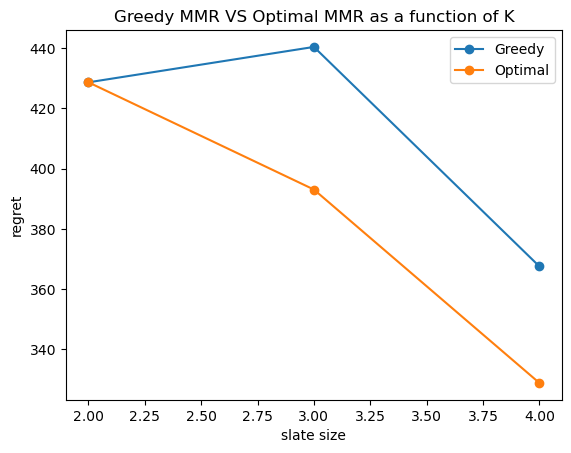

In [8]:
plt.plot(K_list,MMR_greedy_list, label='Greedy', marker="o")
plt.plot(K_list,MMR_optimal_list, label='Optimal', marker="o")
plt.title('Greedy MMR VS Optimal MMR as a function of K')
plt.ylabel('regret')
plt.xlabel('slate size')
plt.legend()
plt.show()

As we can see, it seems that the greedy regret is always higher that the optimal regret, except when $K=1$.<br>
It is only logical since if the greedy slate is optimal we will achieve the same slate in the optimal algorithm, but the opposite can be said.<br>
In $K=1$ both must be equal since the approaches to compute PMR are identicals.

### Runtime:
<br>
As we discussed in the results in part A, the greedy robust optimization algorithm with minimax regret, provides an effective solution in polynomial time $O(nm^3 K^2 )$ where $K$ is the slate size, $m$ is the number of candidates and $n$ is the number of voters.<br>

Instead of computing the $MR(\bar{a},p)$ for each size $K$ slate $\bar{a}$ and selecting the slate that minimizes regret in the optimal algorithm (costs $O(nm^{2K+1} K^2 )$), we are building the slate $\bar{a}$ by iterations until we get a slate of size $K$ (costs $O(nm^3 K^2 )$).<br>
At each iteration $k\leqslant K$, we add the option with the least max regret given the prior items, to the slate.<br>

In [9]:
def get_partial_profiles(full_profiles, candidates, m=10):
    """
    Get partial profiles from the full profiles
    :param full_profiles: dictionary of lists: preference profiles
    :param candidates: list: list of candidates
    :param m: int: number of candidates
    :return: dictionary of lists: partial preference profiles
    """
    partial_profiles = {}
    new_candidates = random.sample(candidates, m)
    for idx, profile in full_profiles.items():
        x = [v for v in profile if v in new_candidates]
        if len(x)>=2:
            size = random.randint(2, len(x))
            idx2sample = random.sample(range(len(x)), size)
            partial_profiles[idx] = [x[i] for i in idx2sample]
    return partial_profiles, new_candidates

candidates =list(np.arange(0,10))
K_list = [2,3]
m_list = [4, 6, 9]


full_profiles = create_full_profiles()

num_voters =100
num_samples =20

table_greedy =[]
table_optimal =[]
for m in m_list:
    row_greedy = []
    row_optimal =[]
    for k in K_list:
        if k>m:
            continue
        print(k,m)
        timer_greedy = 0
        timer_optimal = 0
        for i in range(num_samples):
            partial_profiles, new_candidates = get_partial_profiles(full_profiles, candidates, m)
            random_partial_profiles = get_random_profiles(partial_profiles, num_voters)
            random_partial_profiles = list(random_partial_profiles.values())
            below_profile, above_profile = get_below_above_profiles(random_partial_profiles)
            start = time.perf_counter()
            greedy_algorithm(k, below_profile, above_profile, new_candidates)
            stop = time.perf_counter()
            timer_greedy += stop - start
            
            start = time.perf_counter()
            optimal_algorithm(k, below_profile, above_profile, new_candidates)
            stop = time.perf_counter()
            timer_optimal += stop - start
            
        row_greedy.append(timer_greedy/num_samples)
        row_optimal.append(timer_optimal/num_samples)
    table_greedy.append(row_greedy)
    table_optimal.append(row_optimal)
df_greedy = pd.DataFrame(table_greedy, columns=K_list, index=m_list)
df_optimal = pd.DataFrame(table_optimal, columns=K_list, index=m_list)


2 4
3 4
2 6
3 6
2 9
3 9


,2,3
4,1.785944,22.114936
6,2.627727,28.810750
9,3.648438,36.580268


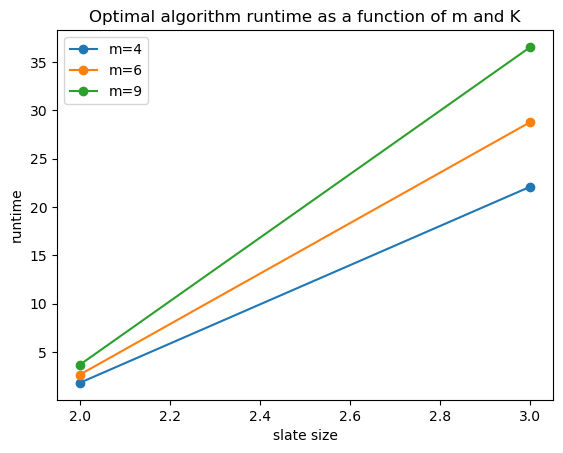

,2,3
4,0.013115,0.025443
6,0.046567,0.084528
9,0.157981,0.272534


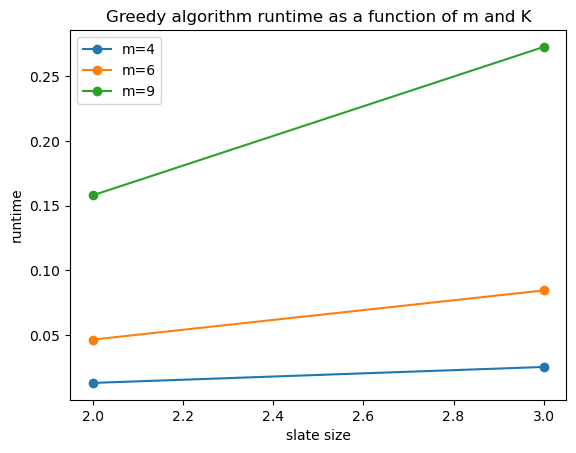

In [10]:
display(df_optimal)
plt.plot(K_list,table_optimal[0], label='m=4', marker="o")
plt.plot(K_list,table_optimal[1], label='m=6', marker="o")
plt.plot(K_list,table_optimal[2], label='m=9', marker="o")
plt.title('Optimal algorithm runtime as a function of m and K')
plt.ylabel('runtime')
plt.xlabel('slate size')
plt.legend()
plt.show()
display(df_greedy)
plt.plot(K_list,table_greedy[0], label='m=4', marker="o")
plt.plot(K_list,table_greedy[1], label='m=6', marker="o")
plt.plot(K_list,table_greedy[2], label='m=9', marker="o")
plt.title('Greedy algorithm runtime as a function of m and K')
plt.ylabel('runtime')
plt.xlabel('slate size')
plt.legend()
plt.show()

We computed the average runtime (for 20 random profiles) on 100 random voters for different sizes of K and m.<br>
As we can see our simulation affirms the result. We can see that the slope of the optimal algorithm is much higher than the slope of the greedy algorithm, for all m. <br> 

As we mentioned in part A and in this part, it is hard to compute MMR for the optimal algorithm and that's why we run the optimal algorithm on small K and m.<br>
Using the sushi dataset with 100 different varieties, (meaning there are 100 candidates) we will inspect the effect of K and m on the running time of the greedy algorithm for bigger K and m values

In [11]:
candidates =list(np.arange(0,100))
K_list = [2,3,4,5]
m_list = [10, 20, 30,40]

Sushi_file = "sushi3b.5000.10.order"
data_file = open(Sushi_file, "r")
data_lines = data_file.read().splitlines()[1:]
full_profiles = {}
for i, line in enumerate(data_lines):
    profile = line.split(" ")[-1:-11:-1]
    profile = [int(c) for c in profile]
    full_profiles[i] = profile


num_voters =100
num_samples =20

table_greedy =[]
table_optimal =[]
for m in m_list:
    row_greedy = []
    row_optimal =[]
    for k in K_list:
        if k>m:
            continue
        print(k,m)
        timer_greedy = 0
        timer_optimal = 0
        for i in range(num_samples):
            partial_profiles, new_candidates = get_partial_profiles(full_profiles, candidates, m)
            random_partial_profiles = get_random_profiles(partial_profiles, num_voters)
            random_partial_profiles = list(random_partial_profiles.values())
            below_profile, above_profile = get_below_above_profiles(random_partial_profiles)
            start = time.perf_counter()
            greedy_algorithm(k, below_profile, above_profile, new_candidates)
            stop = time.perf_counter()
            timer_greedy += stop - start
            
        row_greedy.append(timer_greedy/num_samples)
    table_greedy.append(row_greedy)
df_greedy = pd.DataFrame(table_greedy, columns=K_list, index=m_list)


2 10
3 10
4 10
5 10
2 20
3 20
4 20
5 20
2 30
3 30
4 30
5 30
2 40
3 40
4 40
5 40


,2,3,4,5
10,0.137414,0.209905,0.304744,0.417883
20,0.837324,1.581838,2.266898,3.281086
30,3.387849,6.098972,8.817385,12.539235
40,7.699073,14.787314,24.449000,27.150900


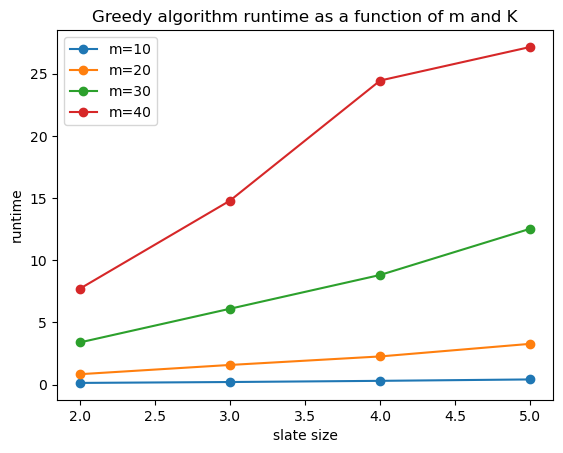

In [12]:
display(df_greedy)
plt.plot(K_list,table_greedy[0], label='m=10', marker="o")
plt.plot(K_list,table_greedy[1], label='m=20', marker="o")
plt.plot(K_list,table_greedy[2], label='m=30', marker="o")
plt.plot(K_list,table_greedy[3], label='m=40', marker="o")
plt.title('Greedy algorithm runtime as a function of m and K')
plt.ylabel('runtime')
plt.xlabel('slate size')
plt.legend()
plt.show()

As we can see, the average runtime increases significantly with the number of candidates m, but less dramatically
with K<br> 
This is consistent with the “quadratic in K” and “cubic in m” computational results above<br>
We can see that for small m and K, we can achieve an optimal solution in linear time.<br>


### MR  as a function of query updates:
<br>
We saw from the paper that the random elicitation strategy on the greedy algorithm (yellow line) is mostly decreasing as a function of the number of queries.<br>
<img src="rand_elication_greedy.JPG" alt="Alternative text" width="500" height="600"/>



In [18]:
def update_random_query(below_profile, above_profile,random_full_profile):
    voter = random.sample(range(0, len(random_full_profile)), 1)[0]
    while len(below_profile[voter].keys()) >= 9:
        voter = random.sample(range(0, len(random_full_profile)), 1)[0]
    flag = True
    above = above_profile[voter]
    below = below_profile[voter]
    while flag:
        a,b = random.sample(candidates, 2)
        if random_full_profile[voter].index(a) > random_full_profile[voter].index(b):
            continue
        else:
            if b in above.keys() and a in below.keys():
                if a in above[b]:
                    continue
            if b in below.keys() and a in above.keys():
                if a in below[b]:
                    continue

            if a not in below.keys():
                below[a] = [b]
            else:
                below[a].append(b)

            if b not in above.keys():
                above[b] = [a]
            else:
                above[b].append(a)
            flag = False
    return below_profile, above_profile

def get_partial_profiles2(full_profiles, candidates, m=10):
    """
    Get partial profiles from the full profiles
    :param full_profiles: dictionary of lists: preference profiles
    :param candidates: list: list of candidates
    :param m: int: number of candidates in the partial profile
    :return: dictionary of lists: partial preference profiles
    """
    partial_profiles = {}
    new_candidates = random.sample(candidates, m)
    for idx, profile in full_profiles.items():
        x = [v for v in profile if v in new_candidates]
        size = random.randint(2, 5)
        idx2sample = sorted(random.sample(range(len(x)), size))
        partial_profiles[idx] = [x[i] for i in idx2sample]
    return partial_profiles, new_candidates

num_samples =20
k = 3
candidates =list(np.arange(0,10))
num_voters =100

avg_MR = defaultdict(int)

full_profile = create_full_profiles()
for i in range(num_samples):
    random_full_profile = get_random_profiles(full_profile, num_voters)
    random_partial_profile, candidates= get_partial_profiles2(random_full_profile, candidates)
    random_full_profile = list(random_full_profile.values())
    random_partial_profile = list(random_partial_profile.values())
    MR_list = []
    below_profile, above_profile = get_below_above_profiles(random_partial_profile)
    MR_K = float("inf")
    cnt =0
    while MR_K<10 or cnt<1000:
        print(cnt,i,end="\r")
        slate, MMR, slate_k_minus_1, w_k, optimal, MR_K = greedy_algorithm(k, below_profile, above_profile, candidates)
        MR_list.append(MR_K)
        below_profile, above_profile = update_random_query(below_profile, above_profile,random_full_profile)
        cnt+=1
    for j,mr in enumerate(MR_list):
        avg_MR[j] += mr

avg_MR = [v / (num_samples*num_voters) for v in avg_MR.values()]



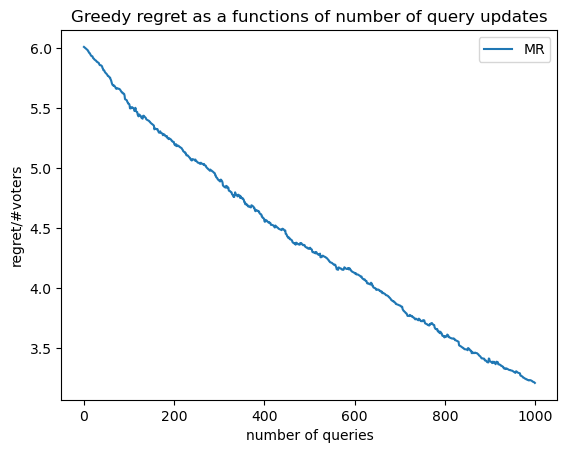

In [19]:
plt.plot(avg_MR, label='MR', )
plt.title('Greedy regret as a functions of number of query updates')
plt.ylabel('regret/#voters')
plt.xlabel('number of queries')
plt.legend()
plt.show()

We computed the conditional MR as a function of the number of queries added to the partial profile (over 20 randomly drawn profiles).<br>
Our location strategy randomly picks a voter and pairwise query (ensuring this query is not implied by that voter’s partial ranking), then we are using Greedy to compute a slate at each round and measure its max regret and minimax regret.<br> 
As we can see the Greedy MR may not decrease monotonically, as preference updates may “mislead” Greedy into choosing an inferior slate (by contrast, true MMR is non-increasing)<br>
It is worth mentioning that according to the paper they started with no vote information, here we start with an existing partial profile and added to it.<br>